# Natural Gas Consumption Demand Forecasting

**<u>Objective:</u>**  
The goal of this project is to forecast the demand for natural gas in Greece for the 12-month period from August 2024 to July 2025, using historical consumption data and temperature as key variables. Accurate forecasting can support energy planning, optimize supply, and reduce costs for industrial, residential, and commercial users.


**<u>Approach:</u>**  
We explore a range of methods for time series forecasting, combining both traditional statistical models and modern machine learning and deep learning approaches:
1) **SARIMA (Seasonal AutoRegressive Integrated Moving Average):**  
A classical statistical time series model that captures trend, seasonality, and autocorrelation in natural gas consumption. It serves as a strong baseline for forecasting.  

2) **XGBoost (Extreme Gradient Boosting):**  
A tree-based ensemble learning method that builds predictive models by combining multiple weak learners. It is well-suited for tabular data with engineered lag and temperature features.  

3) **MLP (Multi-Layer Perceptron):**  
A fully connected feedforward neural network with two hidden layers. It learns nonlinear mappings between past consumption, temperature, and future demand but does not explicitly account for sequential or temporal dependencies.  

4) **RNN (Recurrent Neural Network):**  
A neural network architecture designed to handle sequential data by passing information across time steps. It captures short-term temporal dependencies in consumption and temperature patterns.  

5) **LSTM (Long Short-Term Memory):**  
An advanced type of RNN that uses gating mechanisms to regulate the flow of information. It addresses the vanishing gradient problem of standard RNNs and can capture long-term dependencies in natural gas consumption trends.  

6) **GRU (Gated Recurrent Unit):**  
A simplified variant of LSTM with fewer gates. It is computationally more efficient while still maintaining the ability to model long-term dependencies in sequential data.  

7) **1D-CNN (One-Dimensional Convolutional Neural Network):**  
A convolutional model applied along the time dimension to extract local temporal patterns. It is effective at detecting short-term fluctuations and combining them with broader trends for forecasting.  




**<u>Data:</u>**
- Consumption data: Historical monthly natural gas consumption in Greece from January 2008 to July 2025 from https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_gasm__custom_18061196/default/table?lang=en.

- Weather data: Monthly average air temperatures retrieved from Meteostat API (daily data aggregated into monthly means) using a weather station located near Athens, Greece.


### **1. Loading and Preparing the dataset**

#### 1.1 Importing the consumption values from the xlsx file to a pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=filter info, 2=filter warnings, 3=errors only
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Suppress TensorFlow warnings
import warnings
warnings.simplefilter("ignore", UserWarning) # Suppress warnings for cleaner output



# Define file path and sheet name of the xlsx file
file_path = "nrg_cb_gasm.xlsx"  
sheet_name = "Sheet 2"

# Load the sheet
consumption_raw = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

# Extract the row with dates (row 10, Python index 9)
dates = consumption_raw.iloc[9, 1:].tolist()  # skip first column which is not a date

# Extract the row with values (row 12, Python index 11)
consumption_values = consumption_raw.iloc[11, 1:].tolist() # skip first column which is not a value

# Create DataFrame
consumption_df = pd.DataFrame({'Consumption_TJ': consumption_values}, 
                              index=pd.to_datetime(dates, format='%Y-%m', errors='coerce'))

# Set index name
consumption_df.index.name = 'Year-Month'

# Convert 'Consumption_TJ' to numeric, forcing errors to NaN
consumption_df['Consumption_TJ'] = pd.to_numeric(consumption_df['Consumption_TJ'], errors='coerce')


# Ensure the index is a DateTimeIndex and set frequency to Month Start
consumption_df = consumption_df.asfreq('MS')  

# Display the first and last few rows of the DataFrame
consumption_df


,Consumption_TJ
Year-Month,
2008-01-01,16246.000
2008-02-01,15292.000
2008-03-01,15040.000
2008-04-01,11418.000
2008-05-01,12974.000
...,...
2025-04-01,14555.433
2025-05-01,15772.260
2025-06-01,20257.030


In [2]:
# Check for missing values
missing_values = consumption_df.isnull().sum()
print("Missing values in the dataset:\n", missing_values)

Missing values in the dataset:
 Consumption_TJ    1
dtype: int64


In [3]:
# Remove rows with non-numeric values
consumption_df = consumption_df[pd.to_numeric(consumption_df['Consumption_TJ'], errors='coerce').notnull()]
# and check again
non_numeric = pd.to_numeric(consumption_df['Consumption_TJ'], errors='coerce').isna().sum()
print("Non-numeric values in the dataset:\n", non_numeric)

Non-numeric values in the dataset:
 0


#### 1.2 Exploratory Data Analysis (EDA)

In [4]:
# Summary statistics of the consumption values
consumption_df['Consumption_TJ'].describe()

count      211.000000
mean     15286.903517
std       4490.524904
min       6031.000000
25%      11905.696000
50%      14576.665000
75%      17889.737000
max      28667.081000
Name: Consumption_TJ, dtype: float64

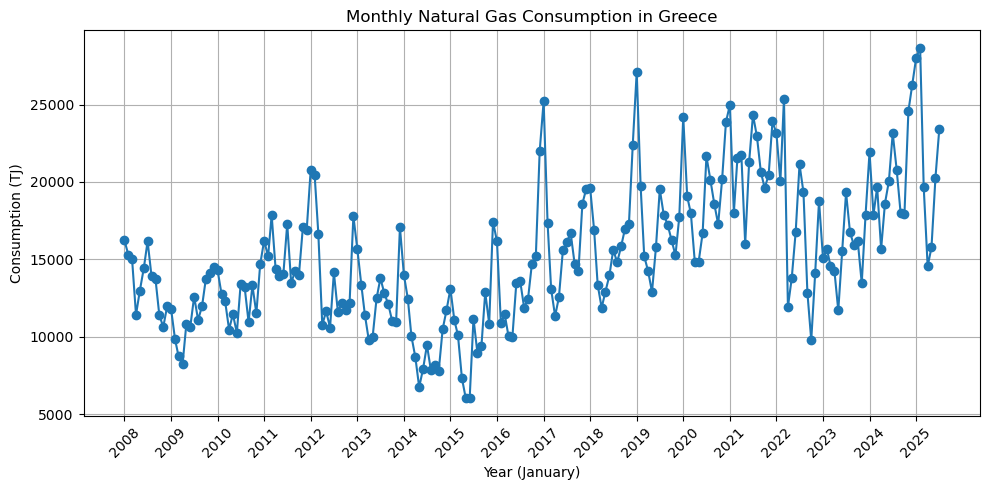

In [5]:
# Create a line plot of all the consumption values
plt.figure(figsize=(10, 5))
plt.plot(consumption_df.index, consumption_df['Consumption_TJ'], marker='o', linestyle='-')
plt.title('Monthly Natural Gas Consumption in Greece')
plt.xlabel('Year (January)')
plt.ylabel('Consumption (TJ)')

# Show only every 12 months
every_n_months = 12
plt.xticks(
    ticks=consumption_df.index[::every_n_months],
    labels=consumption_df.index[::every_n_months].strftime('%Y'),
    rotation=45
)

plt.grid(True)
plt.tight_layout()
plt.show()

> Comment:
- From the actual consumption plot in the EDA, we observed a clear decrease in overall consumption from February 2022 until late 2024. This decline is attributed to the Russia–Ukraine energy crisis.

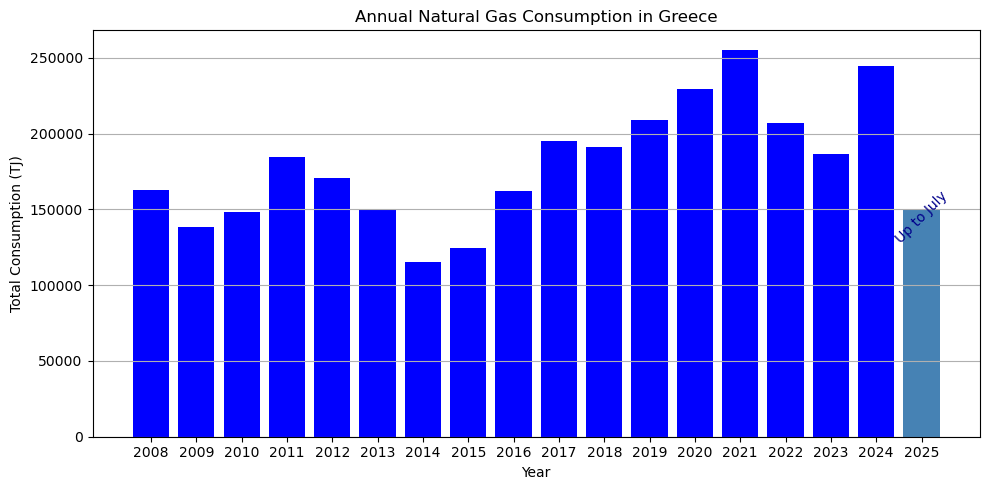

In [6]:
# Create a bar plot of the consumption values for each year additively to see the year trend more clearly

# Create a copy of the original DataFrame to extend it with 'Year' column for visualization purposes
consumption_df_extended = consumption_df.copy()

# Aggregate the data by year
consumption_df_extended['Year'] = consumption_df_extended.index.year
annual_consumption = consumption_df_extended.groupby('Year')['Consumption_TJ'].sum().reset_index()

# Define colors: all blue except last bar (2025) in steelblue
colors = ['blue'] * (len(annual_consumption) - 1) + ['steelblue']  

plt.figure(figsize=(10, 5))
plt.bar(annual_consumption['Year'], annual_consumption['Consumption_TJ'], color=colors)
plt.title('Annual Natural Gas Consumption in Greece')
plt.xlabel('Year')
plt.ylabel('Total Consumption (TJ)')

# Add note about the last bar
plt.text(annual_consumption['Year'].iloc[-1], 
         annual_consumption['Consumption_TJ'].iloc[-1]*0.85,
         'Up to July', ha='center', color='darkblue', rotation=45)

plt.xticks(annual_consumption['Year'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()


 > Explanation of the annual trend:

- 2009: Sharp drop after 2008 due to the global financial crisis, reducing industrial and residential demand.
- 2010–2011: Partial recovery as the economy adjusted, possibly with colder winters increasing heating demand.
- 2012–2013: Decline during the Greek debt crisis and austerity measures.
- 2014: Lowest consumption in the dataset, influenced by economic recession and mild weather.
- 2015–2016: Consumption rebounds with industrial stabilization and higher electricity demand.
- 2017–2021: Sustained growth driven by gas-fired power plant expansion, industrial demand, and electricity generation needs.
- 2022–2023: Drop caused by the European energy crisis and high gas prices, prompting reduced consumption.

>

>

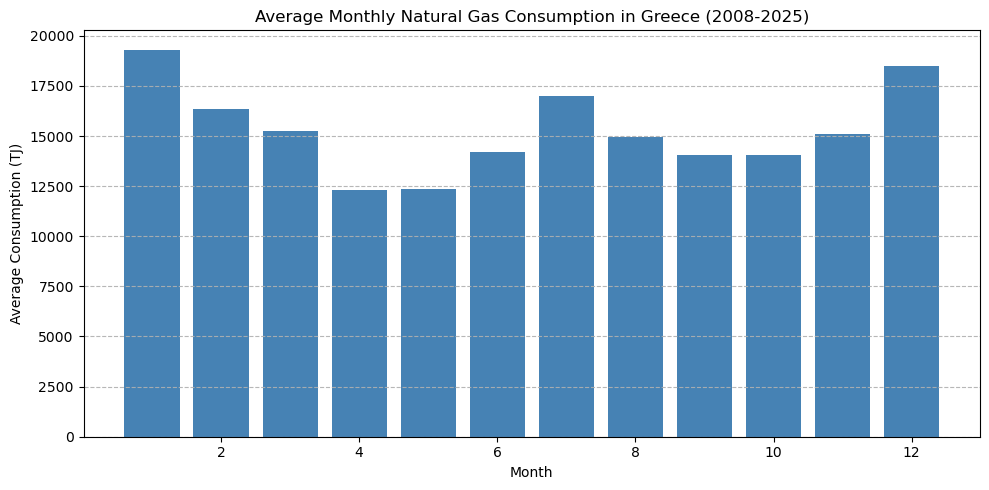

In [7]:
# Create a bar plot of the consumption values for each calendar month to see the month trend more clearly

# Extract month number
consumption_df_extended.loc[:, 'Month_Num'] = consumption_df_extended.index.month

# Aggregate by month (mean or sum, depending on your choice)
monthly_trend = consumption_df_extended.groupby('Month_Num')['Consumption_TJ'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.bar(monthly_trend['Month_Num'], monthly_trend['Consumption_TJ'], color='steelblue')
plt.title('Average Monthly Natural Gas Consumption in Greece (2008-2025)')
plt.xlabel('Month')
plt.ylabel('Average Consumption (TJ)')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

> Explanation of the Monthly Trend:

- The months with the highest consumption are January and December, which is expected since natural gas is primarily used for heating, and these two months are generally the coldest.

- July surprisingly also shows high consumption, even higher than February and March. During summer, although heating demand is low, industrial activity and electricity production can increase. Electricity demand for cooling (air conditioning) rises in July and August, and some power plants operate on natural gas, which can push up natural gas consumption in the summer months.

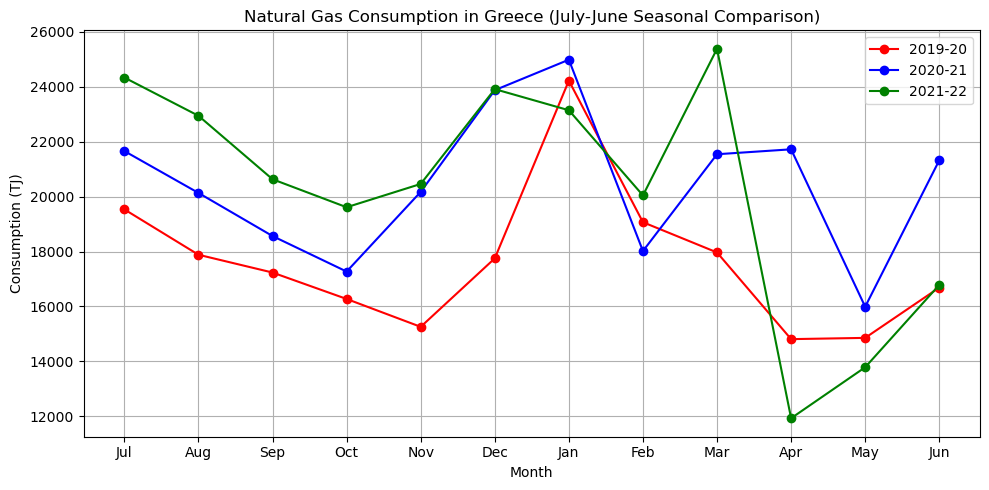

In [8]:
# Create some line plots of 12-month periods from July to June to see the seasonal trend more clearly

# Define periods
periods = [
    ('2019-07-01', '2020-06-30', '2019-20', 'red'),
    ('2020-07-01', '2021-06-30', '2020-21', 'blue'),
    ('2021-07-01', '2022-06-30', '2021-22', 'green')
]

plt.figure(figsize=(10, 5))

for start_date, end_date, label, color in periods:
    # Filter using the DatetimeIndex
    period_df = consumption_df[(consumption_df.index >= start_date) &
                               (consumption_df.index <= end_date)].copy()

    # Create "Month name" column for aligning periods
    period_df['Month'] = period_df.index.strftime('%b')

    # Plot with month on x-axis
    plt.plot(period_df['Month'], period_df['Consumption_TJ'],
             marker='o', linestyle='-', color=color, label=label)

plt.title('Natural Gas Consumption in Greece (July-June Seasonal Comparison)')
plt.xlabel('Month')
plt.ylabel('Consumption (TJ)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


> We observe a seasonal pattern:
- Higher demand usually occurs in December, January, and July.
- Medium demand is seen in August and June.
- Lower demand appears in February, April, May, September, and October.
- Demand fluctuates in March, probably depending on temperature.

In [9]:
# We will find and add the monthly temperature data for Athens, Greece from 2008 to 2025 using the Meteostat library.
from meteostat import Stations, Daily


# 1) Search for stations near Athens
stations = Stations().region('GR').nearby(37.98, 23.72)
st = stations.fetch(10).reset_index()
print(st[['id', 'name', 'country', 'elevation']])

      id                        name country  elevation
0  16714    Athens / Athenai / Pláka      GR      107.0
1  16716             Athinai Airport      GR       28.0
2  16715                       Tatoi      GR      239.0
3  16718             Elefsis Airport      GR       44.0
4  16741       El Venizelos / Liádha      GR       72.0
5  16699             Tanagra Airport      GR      148.0
6  16710            Tripolis Airport      GR      644.0
7  16684              Skyros Airport      GR       27.0
8  LGSK0  Skiathos Island / Skíathos      GR       15.0
9  16675                       Lamia      GR      144.0


> After some tests we select the Elefsis Airport station because it has all the required temperature data (01/2008 to 07/2025)

In [10]:
# 2) So we choose station 16718 - Elefsis Airport
station_id = st['id'].iloc[3]   

# 3) Get daily data for 2008-01-01 to 2025-07-31
start = pd.Timestamp('2008-01-01')
end   = pd.Timestamp('2025-07-31')
daily = Daily(station_id, start, end).fetch()

# 4) Use tavg (temperature average) if available, otherwise compute it
if 'tavg' not in daily.columns or daily['tavg'].isna().all():
    daily['tavg'] = daily[['tmin','tmax']].mean(axis=1)

# 5) Aggregate to monthly mean temperature
monthly_temp = daily['tavg'].resample('MS').mean().to_frame(name='temp_C')
monthly_temp.index.name = 'Year-Month'
monthly_temp.index = pd.to_datetime(monthly_temp.index)

In [11]:
# Check for missing values
monthly_temp.isnull().sum()  

temp_C    0
dtype: int64

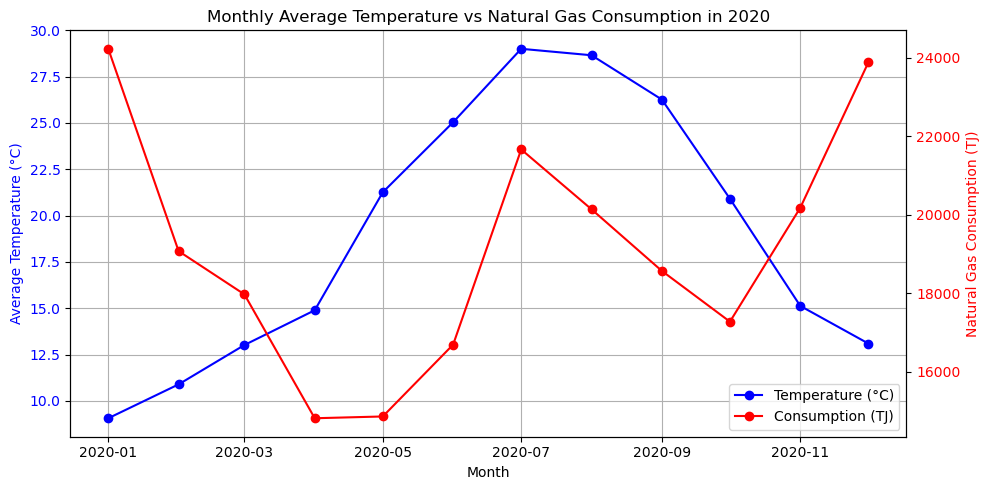

In [12]:
# We will plot the monthly temperature data for a test year (2020) along with the consumption data of that year
# Filter for 2020
temp_2020 = monthly_temp[monthly_temp.index.year == 2020]
cons_2020 = consumption_df[consumption_df.index.year == 2020]

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot temperature on left y-axis
ax1.plot(temp_2020.index, temp_2020['temp_C'], marker='o', color='blue', label='Temperature (°C)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Temperature (°C)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for consumption
ax2 = ax1.twinx()
ax2.plot(cons_2020.index, cons_2020['Consumption_TJ'], marker='o', color='red', label='Consumption (TJ)')
ax2.set_ylabel('Natural Gas Consumption (TJ)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Monthly Average Temperature vs Natural Gas Consumption in 2020')
ax1.grid(True)

# Optional: show legends for both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower right')

plt.tight_layout()
plt.show()


> We see the correlation between temperature and consumption:
- Very high (> 27°C) or very low (< 14°C) temperatures increase the natural gas consumption

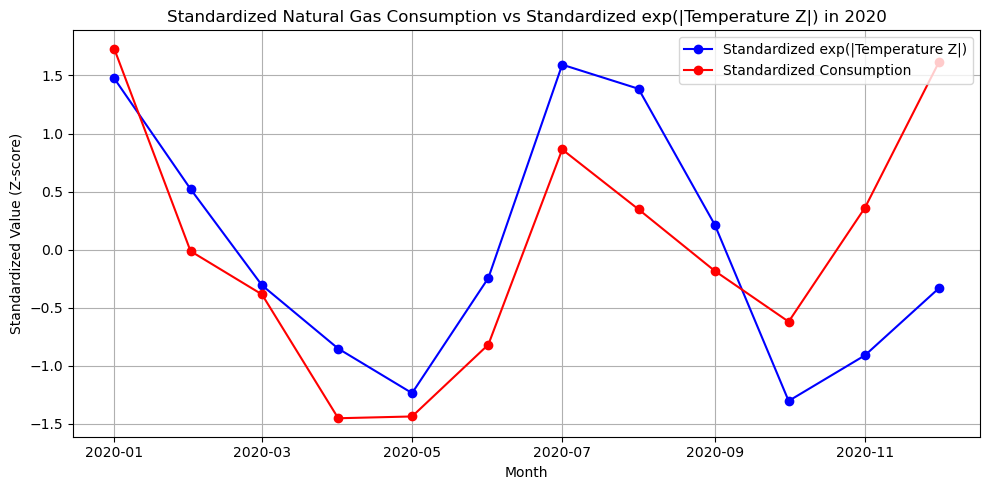

In [13]:
# We will make a plot of the standardized consumption and the standardized exp(|standardized temperature|) 
# to have both series in the same scale and compare their correlations more easily

# We used the absolute value of the standardized temperature because the consumption is high for low temperatures (winter)
# and low for high temperatures (summer), so the relationship is not linear but rather exponential in absolute terms.


# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cons_std = scaler.fit_transform(cons_2020[['Consumption_TJ']])
temp_std = scaler.fit_transform(temp_2020[['temp_C']])

# Exponential absolute standardized temperature
temp_exp_abs = np.exp(np.abs(temp_std))

# Re-standardize the transformed temperature
temp_exp_abs_std = StandardScaler().fit_transform(temp_exp_abs)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(temp_2020.index, temp_exp_abs_std, marker='o', color='blue', label='Standardized exp(|Temperature Z|)')
plt.plot(cons_2020.index, cons_std, marker='o', color='red', label='Standardized Consumption')

plt.title('Standardized Natural Gas Consumption vs Standardized exp(|Temperature Z|) in 2020')
plt.xlabel('Month')
plt.ylabel('Standardized Value (Z-score)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

> From the above plot we clearly see the correlation between the exponential of the absolute standardized temperature and standardized consumption.

### **2. Forecasting models**

#### 2.1 Seasonal Autoregressive Integrated Moving Average (SARIMA) model

In [14]:
# In our SARIMA model we will only use the previous consumption values (not temperature values)
# Split into training and test sets 
n_test = 12  # last 12 months as test set
consumption_train = consumption_df.iloc[:-n_test]
consumption_test = consumption_df.iloc[-n_test:]

In [15]:
# Check lengths
print(f'Test set length: {len(consumption_test)}')
print(f'Train set length: {len(consumption_train)}')

Test set length: 12
Train set length: 199


> SARIMA model uses some parameters (p,d,q,P,D,Q,s). In order to find the most appropriate values for these parameters we will perform some relevant tests

In [16]:
# SARIMA model uses some parameters (p,d,q,P,D,Q,s). In order to find the most appropriate values 
# for these parameters we will perform some relevant tests

# Perform Augmented Dickey-Fuller (ADF) test on the training set to check for stationarity as it is needed for SARIMA modeling
from statsmodels.tsa.stattools import adfuller

result = adfuller(consumption_train['Consumption_TJ'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.032965617771203
p-value: 0.27230843876962685


> p-value is larger than 0.05 which means No stationarity (mean and variance not constant)

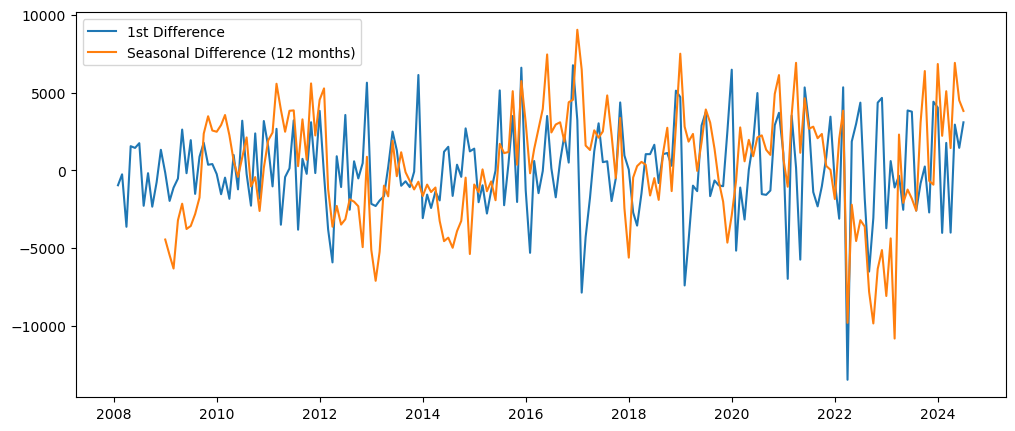

In [17]:
# Since p-value is larger than 0.05, the series is non-stationary. We will difference the series and check again.
consumption_train_diff = consumption_train['Consumption_TJ'].diff().dropna()
consumption_train_diff_seasonal = consumption_train['Consumption_TJ'].diff(12).dropna()  # seasonal differencing
consumption_train_diff_combined = consumption_train['Consumption_TJ'].diff().diff(12).dropna()

# Plot the differenced series to visualize the effect of differencing
plt.figure(figsize=(12,5))
plt.plot(consumption_train_diff, label='1st Difference')
plt.plot(consumption_train_diff_seasonal, label='Seasonal Difference (12 months)')
plt.legend()
plt.show()


In [18]:

result = adfuller(consumption_train_diff_combined)  # or train_diff / train_seasonal_diff
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -5.122208649196952
p-value: 1.2646871757445217e-05


> now p-value is way lower than 0.05 so our series is ready for the SARIMA model

For the SARIMA model we need to specify seven parameters:
SARIMA(p,d,q)(P,D,Q,s)

> Non-seasonal parameters:
- p = order of AR (autoregressive)
- d = order of differencing
- q = order of MA (moving average)

> Seasonal parameters:
- P = seasonal AR order
- D = seasonal differencing order
- Q = seasonal MA order
- s = seasonal period (for monthly data with yearly seasonality, s=12)

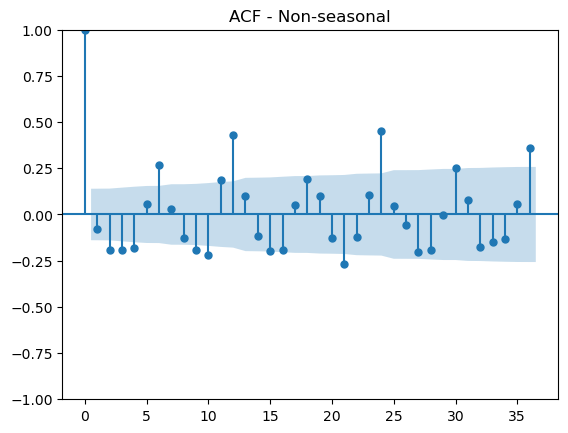

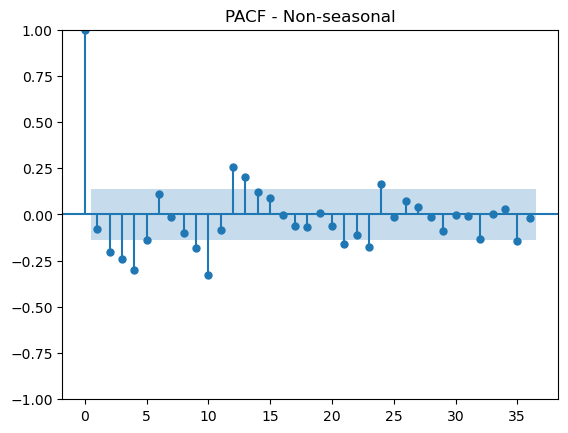

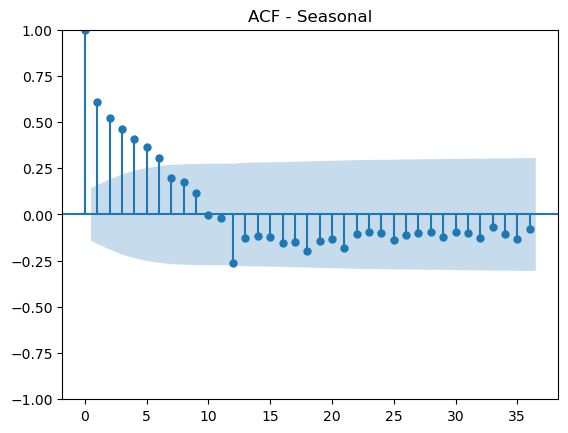

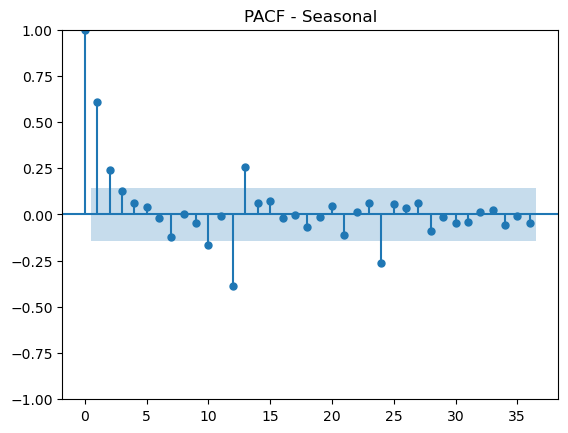

In [19]:
# ACF and PACF plots reveal correlation patterns and seasonality in the data, guiding the selection 
# of SARIMA model parameters.
# In ACF plots, significant spikes at specific lags suggest correlation patterns and seasonality. 
# In PACF plots, a sharp cutoff after a lag indicates the autoregressive order (p or P). 
# Seasonal plots highlight repeating patterns at the seasonal period, helping set seasonal parameters for SARIMA.

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Non-seasonal
plot_acf(consumption_train_diff, lags=36)
plt.title('ACF - Non-seasonal')
plt.show()

plot_pacf(consumption_train_diff, lags=36)
plt.title('PACF - Non-seasonal')
plt.show()

# Seasonal
plot_acf(consumption_train_diff_seasonal, lags=36)
plt.title('ACF - Seasonal')
plt.show()

plot_pacf(consumption_train_diff_seasonal, lags=36)
plt.title('PACF - Seasonal')
plt.show()


> Good p, q, P and Q values are usually fairly small (typically 0 to 2, sometimes up to 5 or 6), and d
and D are typically 0 or 1, sometimes 2. From the plots we narrow down the possible best parameter values to:
- p = 0 or 1
- d = 1
- q = 0 or 1
- P = 1
- D = 1
- Q = 0
- s = 12

> But AIC search is the real test. AIC search is testing different model settings and choosing the one with the lowest Akaike Information Criterion (AIC), which balances fit quality and model complexity. It tells us empirically which model balances goodness of fit and complexity. So we will expand our grid search with the values:
- P = 0
- D = 0
- Q = 1

In [20]:
import itertools
import statsmodels.api as sm

# Candidate parameters based on our ACF/PACF observations
p = [0, 1]   # AR order
d = [1]      # Differencing order (we already saw it needs 1)
q = [0, 1]   # MA order
P = [0, 1]   # Seasonal AR order
D = [0, 1]      # Seasonal differencing
Q = [0, 1]      # Seasonal MA order (we saw Q not strong)
s = 12       # Seasonal period

# Generate combinations
param_grid = list(itertools.product(p, d, q, P, D, Q))


results = []

for (p_, d_, q_, P_, D_, Q_) in param_grid:
    try:
        model = sm.tsa.SARIMAX(
            consumption_train['Consumption_TJ'],
            order=(p_, d_, q_),
            seasonal_order=(P_, D_, Q_, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        results.append(((p_, d_, q_, P_, D_, Q_), model_fit.aic))
    except Exception as e:
        print(f"Failed params: {(p_,d_,q_,P_,D_,Q_)} -> {e}")
        continue

# Sort by AIC
results = sorted(results, key=lambda x: x[1])

# Print top models
for params, aic in results[:5]:
    print(f"SARIMA{params}12 - AIC:{aic}")


SARIMA(0, 1, 1, 0, 1, 1)12 - AIC:3150.2977920113
SARIMA(1, 1, 1, 0, 1, 1)12 - AIC:3150.7296186403146
SARIMA(0, 1, 1, 1, 1, 1)12 - AIC:3151.788617407604
SARIMA(1, 1, 1, 1, 1, 1)12 - AIC:3152.2254917238106
SARIMA(1, 1, 0, 0, 1, 1)12 - AIC:3182.6718393878386


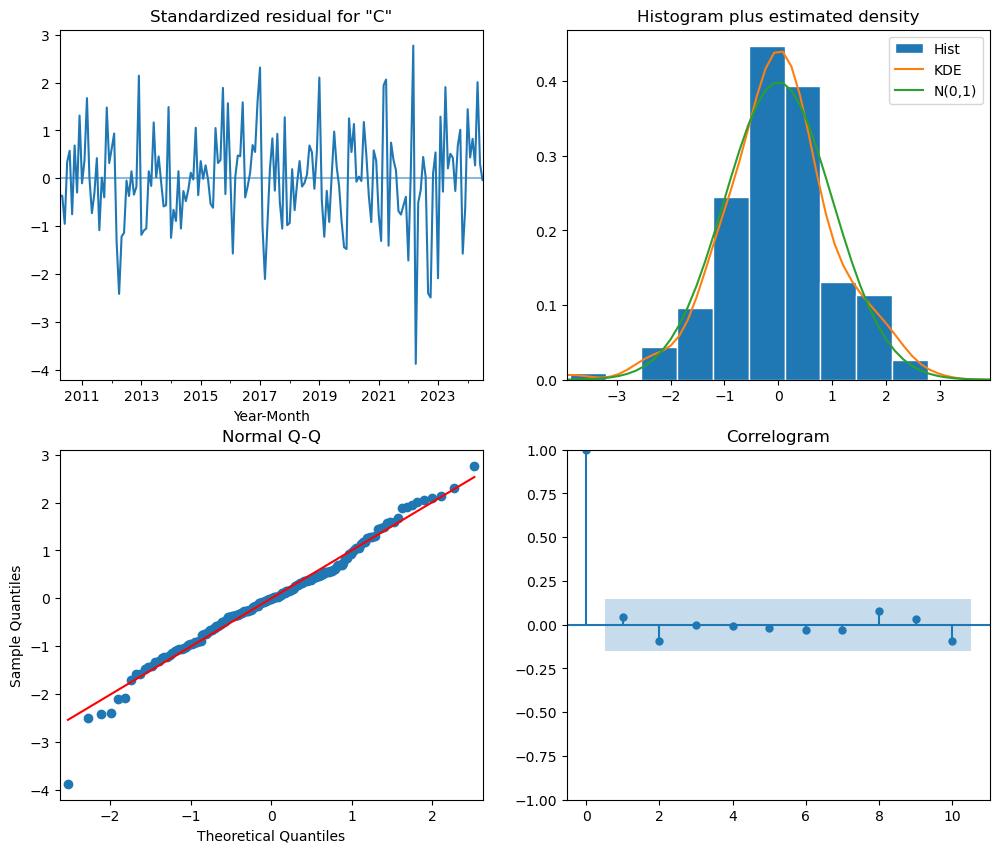

In [21]:
# Fit the model using the best parameters found
best_order = (0, 1, 1)
best_seasonal = (0, 1, 1, 12)


best_model = sm.tsa.SARIMAX(
    consumption_train['Consumption_TJ'],
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Plot diagnostics
best_model.plot_diagnostics(figsize=(12, 10))
plt.show()


> Interpretation of diagnostics:
- 1. Standardized residuals: Should look like white noise (no patterns). --> Pass
- 2. Histogram + KDE: Should resemble a normal distribution. --> Pass
- 3. QQ plot: Points should fall along the 45-degree line, indicating normality. --> Pass
- 4. Correlogram (ACF plot): Most autocorrelations should be within the confidence intervals, indicating no significant autocorrelation. --> Pass

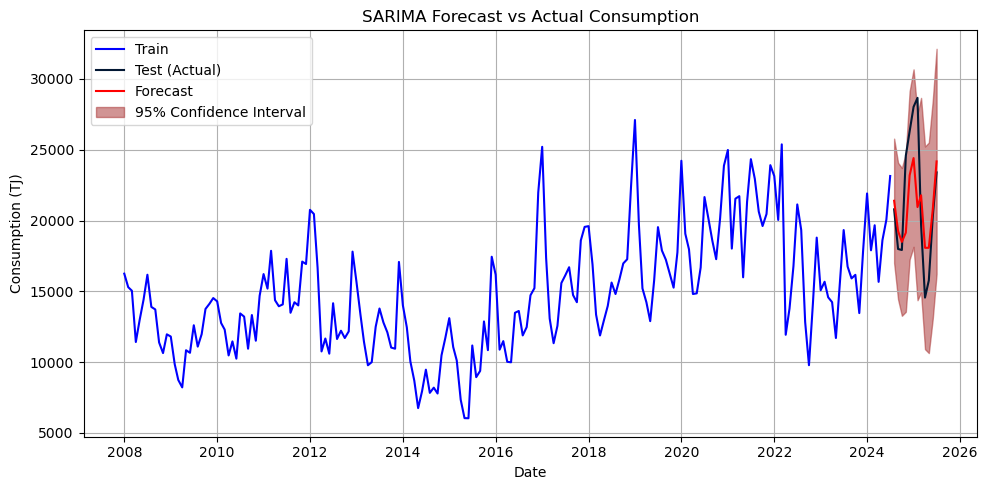

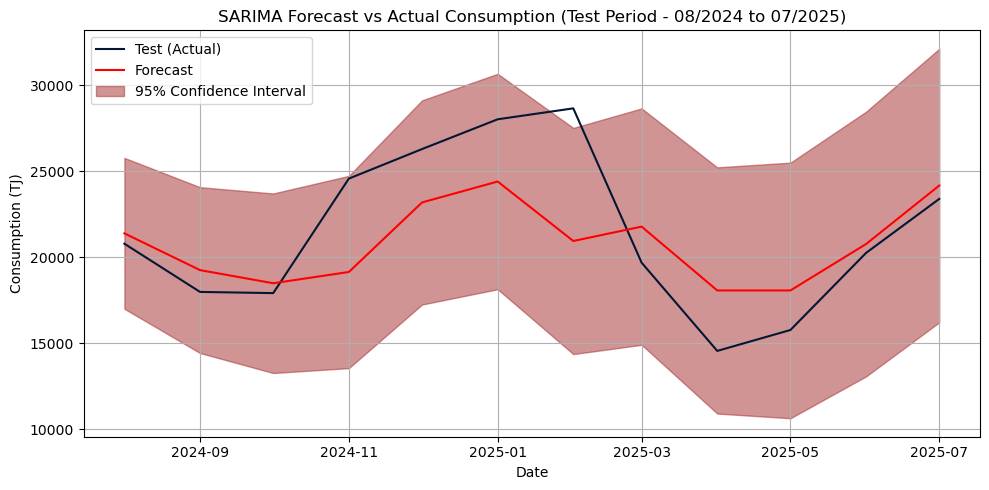

In [22]:
# SARIMA FORECASTING AND EVALUATION

# Forecast for the test period 
forecast = best_model.get_forecast(steps=n_test)
y_pred_sarima = forecast.predicted_mean
forecast_ci = forecast.conf_int() # for plotting confidence intervals

# Plot Actual vs Predicted (including the train set)
plt.figure(figsize=(10, 5))
plt.plot(consumption_train.index, consumption_train['Consumption_TJ'], label="Train", color="blue")
plt.plot(consumption_test.index, consumption_test['Consumption_TJ'], label="Test (Actual)", color="#021733")
plt.plot(consumption_test.index, y_pred_sarima, label="Forecast", color="red")

# Confidence intervals
plt.fill_between(consumption_test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="brown", alpha=0.5, label="95% Confidence Interval")

plt.title("SARIMA Forecast vs Actual Consumption")
plt.xlabel("Date")
plt.ylabel("Consumption (TJ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted (only on the test period) 
plt.figure(figsize=(10, 5))
plt.plot(consumption_test.index, consumption_test['Consumption_TJ'], label="Test (Actual)", color="#021733")
plt.plot(consumption_test.index, y_pred_sarima, label="Forecast", color="red")

# Confidence intervals
plt.fill_between(consumption_test.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="brown", alpha=0.5, label="95% Confidence Interval")

plt.title("SARIMA Forecast vs Actual Consumption (Test Period - 08/2024 to 07/2025)")
plt.xlabel("Date")
plt.ylabel("Consumption (TJ)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Confidence Intervals Explanation**

The shaded area represents the **95% confidence interval** around the forecast.  
This means that, given the SARIMA model and its estimated uncertainty, there is a  
95% probability that the *true future values* will lie within this band.  

- A narrower band indicates higher model certainty.  
- A wider band indicates higher uncertainty in the predictions.  
- Note: the interval reflects statistical uncertainty from the model, not  
  external shocks (e.g., sudden policy changes, extreme weather, etc.).  


In [23]:
# We will calculate two Evaluation metrics: Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
# We will use these values to compare with other models later
from sklearn.metrics import mean_absolute_error, mean_squared_error
sarima_mae = mean_absolute_error(consumption_test['Consumption_TJ'], y_pred_sarima)
sarima_mse = mean_squared_error(consumption_test['Consumption_TJ'], y_pred_sarima)
sarima_rmse = np.sqrt(sarima_mse)
print(f'SARIMA Mean Absolute Error (MAE): {round(sarima_mae,2)}')
print(f'SARIMA Root Mean Squared Error (RMSE): {round(sarima_rmse,2)}')

SARIMA Mean Absolute Error (MAE): 2627.43
SARIMA Root Mean Squared Error (RMSE): 3379.55


#### 2.2 eXtreme Gradient Boosting Trees (XGBoost) model

In [24]:
# For the XGBoost model we will need a supervised-learning format dataset with lagged features.

# Split the data into train and test
train_series = consumption_df.iloc[:-n_test, 0]  # consumption values
test_series = consumption_df.iloc[-n_test:, 0]

# Create lag features for training data only, to avoid data leakage
n_lags = 12


def create_lagged_features(series, n_lags):
    df = pd.DataFrame({'y': series})
    for i in range(1, n_lags+1):
        df[f'lag_{i}'] = pd.to_numeric(series.shift(i), errors='coerce')
    df = df.dropna()
    df.index = series.index[n_lags:]
    return df


train_supervised = create_lagged_features(train_series, n_lags=n_lags)

# Add temperature data (aligned) and ensure numeric type
train_supervised = train_supervised.join(
    monthly_temp.loc[train_supervised.index].astype(float),
    how='inner'
)


# For the test set, we keep only temperature (lag features will be created recursively later)
test_supervised = pd.DataFrame({
    'y': test_series,
    'temperature': monthly_temp.iloc[:, 0].loc[test_series.index]
})

# Split train data into X_train and y_train
X_train = train_supervised.drop(columns=['y'])
y_train = train_supervised['y']

# Split test data into X_test and y_test
X_test = test_supervised.drop(columns=['y'])
y_test = test_supervised['y']

# Check the shapes of the created datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (187, 13)
y_train shape: (187,)
X_test shape: (12, 1)
y_test shape: (12,)


In [25]:
# XGBOOST FORECASTING AND EVALUATION

from xgboost import XGBRegressor

# Initialize model (you can tune hyperparameters later)
xgb_model = XGBRegressor(
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,
    objective='reg:squarederror',
    subsample=0.8,           # keep some randomness
    colsample_bytree=0.8,    # sampling columns
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
# Predict on test set using predicted lag features month by month
# We will use a recursive strategy to predict one month at a time, updating lag features with
# our own predictions.
# This is necessary because lag features depend on previous predictions.


# Store predictions
y_pred_recursive_xgb = []
last_known = list(train_series.iloc[-n_lags:])  # last n_lags of train data

# Recursive prediction
for i in range(len(X_test)):  # loop over all test months
    # Create input: lag features + temperature from X_test
    X_input = np.array(list(last_known[-n_lags:]) + [X_test.iloc[i]['temperature']]).reshape(1, -1)
    
    # Predict
    next_pred = xgb_model.predict(X_input)[0]
    
    # Save prediction
    y_pred_recursive_xgb.append(next_pred)
    
    # Update lag buffer
    last_known.append(next_pred)


# Convert to pandas Series with proper datetime index
forecast_index = pd.date_range(start='2024-08-01', periods=12, freq='MS')
y_pred_recursive_xgb = pd.Series(y_pred_recursive_xgb, index=forecast_index)


In [27]:
# Calculate MAE and RMSE for XGBoost and compare
xgboost_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_xgb)
xgboost_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_xgb)
xgboost_rmse = np.sqrt(xgboost_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03


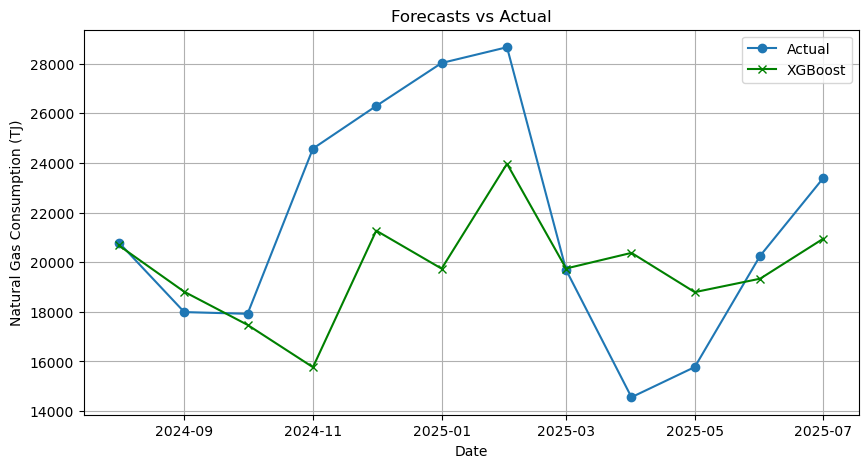

In [28]:
# Plot actuals vs predicted
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual')
plt.plot(test_supervised.index, y_pred_recursive_xgb, marker='x', label='XGBoost', color='green')
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()


**Comment:**  
- We see that XGBoost shows weaker performance with higher MAE and RMSE than SARIMA, even though  SARIMA did not incorporate temperature as a feature. 

#### 2.3 Multi-Layer Perceptron (MLP) deep learning model

In [29]:
# MLP FORECASTING AND EVALUATION

# For the Multi-Layer Perceptron (MLP) deep learning model we will use the datasets with the lag features and temperature
# that we created earlier 
from sklearn.neural_network import MLPRegressor


# Scale target (recommendation for MLP)
from sklearn.preprocessing import StandardScaler
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # shape (n_train,)


# Train MLP using a pipeline that first scales the train set
from sklearn.pipeline import make_pipeline
mlp_pipeline = make_pipeline(
    StandardScaler(),  # scales features (lags + temperature)
    MLPRegressor(hidden_layer_sizes=(200, 100), 
                activation='relu', 
                solver='adam',
                max_iter=3000,
                early_stopping=True,
                n_iter_no_change=15,
                tol=1e-4,
                alpha=0.001, # L2 regularization term
                random_state=42,
                verbose=False)
)

mlp_pipeline.fit(X_train, y_train_scaled)


# Predictions:
# We will use a recursive strategy to predict one month at a time, updating lag features with
# our own predictions.
# This is necessary because lag features depend on previous predictions.

last_known = list(train_series.iloc[-n_lags:])  # last n_lags of train data

y_pred_recursive_mlp = []

for i in range(len(X_test)):  # loop over all test months
    # Build input in the same column order used during training: [lag_1, lag_2, ..., lag_n, temp]
    X_input = np.array(list(last_known[-n_lags:]) + [X_test.iloc[i]['temperature']]).reshape(1, -1)

    # predict scaled target (pipeline scales features internally)
    pred_scaled = mlp_pipeline.predict(X_input)[0]

    # inverse scale to original units (do this ONCE)
    pred_orig = scaler_y.inverse_transform([[pred_scaled]])[0, 0]

    # save prediction
    y_pred_recursive_mlp.append(pred_orig)

    # update last_known: drop the oldest lag and prepend the new (keep order lag_1..lag_n)
    last_known = [pred_orig] + last_known[:-1]


# Convert to array
y_pred_recursive_mlp = np.array(y_pred_recursive_mlp)

In [30]:
# Calculate MAE and RMSE for MLP and compare
mlp_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_mlp)
mlp_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_mlp)
mlp_rmse = np.sqrt(mlp_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}, MLP RMSE: {mlp_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03
MLP MAE: 3076.47, MLP RMSE: 3763.76


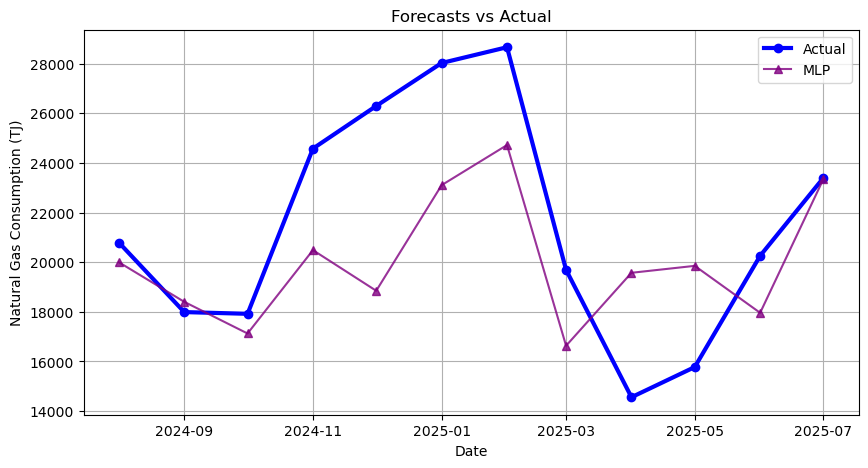

In [31]:
# Plot actuals vs predictions 
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual', color='blue', linewidth=3)
plt.plot(test_supervised.index, y_pred_recursive_mlp, marker='^', label='MLP', color='purple', alpha=0.8)
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**
- The MLP outperforms XGBoost but remains slightly behind SARIMA. It captures nonlinear patterns well, yet its December and April–May forecasts were less accurate. With tuning and more data, it has strong potential for improved performance, especially on longer horizons.

#### 2.4 Simple Recurrent Neural Network (RNN) 

In [32]:
# RNN FORECASTING AND EVALUATION

# Unlike the previous models where we flatten lags into columns, an RNN needs a 3D array
# (X_samples, timesteps, features)


# we will set the seed number to 42 for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Create dataset for RNN 
def create_rnn_dataset(series, temps, n_lags=12):
    series = np.asarray(series)  
    temps  = np.asarray(temps)
    X, y = [], []
    for i in range(n_lags, len(series)):
        # sequence of (consumption, temp) for past n_lags months
        X.append(np.column_stack([series[i-n_lags:i], temps[i-n_lags:i]]))
        # target is gas consumption of current month
        y.append(series[i])
    return np.array(X), np.array(y)


# Training set
X_train_rnn, y_train_rnn = create_rnn_dataset(y_train, X_train.loc[:, 'temp_C'], n_lags=n_lags)



# For the Test set (we append last n_lags from training to start test window)
# Get training tail (last n_lags rows)
train_tail_consumption = y_train.values[-n_lags:]
train_tail_temp        = X_train['temp_C'].values[-n_lags:]

# Get full test series
test_consumption = y_test.values
test_temp        = X_test['temperature'].values

# Concatenate
series_full = np.concatenate([train_tail_consumption, test_consumption])
temps_full  = np.concatenate([train_tail_temp, test_temp])

# Build dataset
X_test_rnn, y_test_rnn = create_rnn_dataset(series_full, temps_full, n_lags=n_lags)



# Scale features + target 
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale X (reshape to 2D first, then back)
n_samples, n_timesteps, n_features = X_train_rnn.shape
X_train_2d = X_train_rnn.reshape(-1, n_features)
X_train_rnn_scaled = scaler_X.fit_transform(X_train_2d).reshape(n_samples, n_timesteps, n_features)

X_test_rnn_scaled = scaler_X.transform(X_test_rnn.reshape(-1, n_features)).reshape(X_test_rnn.shape)

# Scale y
y_train_rnn_scaled = scaler_y.fit_transform(y_train_rnn.reshape(-1,1)).ravel()
y_test_rnn_scaled  = scaler_y.transform(y_test_rnn.reshape(-1,1)).ravel()

# Build RNN model 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout


model_rnn = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(n_lags, 2)),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])


from tensorflow.keras.optimizers import Adam
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mae')


history = model_rnn.fit(
    X_train_rnn_scaled, y_train_rnn_scaled,
    epochs=120,
    batch_size=16,
    validation_split=0.1,
    verbose=0
)

# Recursive multi-step forecasting
y_pred_recursive_rnn = []

# Start with last training sequence (scaled features)
last_sequence = X_train_rnn_scaled[-1].copy()   # shape (n_lags, 2)


for i in range(12):
    # (a) Predict scaled target
    next_pred_scaled = model_rnn.predict(last_sequence.reshape(1, n_lags, 2), verbose=0)[0,0]
    
    # (b) Convert back to original scale
    next_pred_orig = scaler_y.inverse_transform([[next_pred_scaled]])[0,0]
    y_pred_recursive_rnn.append(next_pred_orig)
    
    # (c) Prepare new entry in **feature space**
    # We need to scale [consumption, temp] as features
    new_entry_orig = np.array([next_pred_orig, test_temp[i]])  # original scale
    new_entry_scaled = scaler_X.transform(new_entry_orig.reshape(1,-1))[0]  # scaled (2,)
    
    # (d) Update rolling window
    last_sequence = np.vstack([last_sequence[1:], new_entry_scaled])

# Convert to array
y_pred_recursive_rnn = np.array(y_pred_recursive_rnn)


In [33]:
# Calculate MAE and RMSE for RNN and compare
rnn_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_rnn)
rnn_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_rnn)
rnn_rmse = np.sqrt(rnn_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}, MLP RMSE: {mlp_rmse:.2f}")
print(f"RNN MAE: {rnn_mae:.2f}, RNN RMSE: {rnn_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03
MLP MAE: 3076.47, MLP RMSE: 3763.76
RNN MAE: 2801.40, RNN RMSE: 3252.99


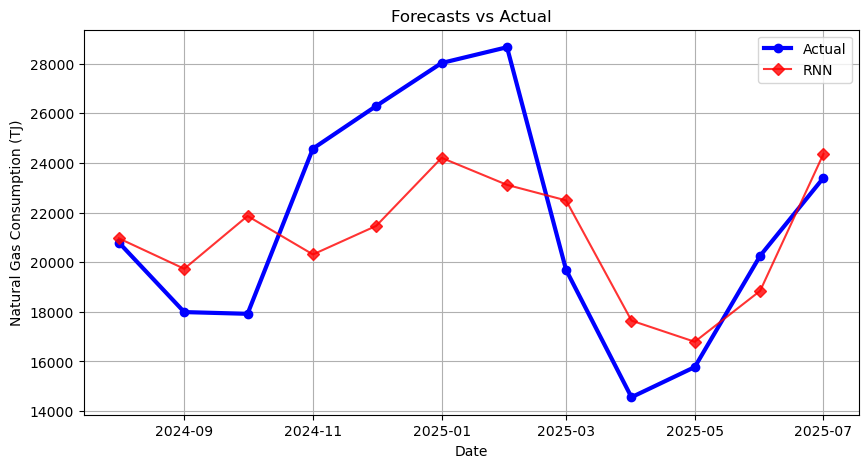

In [34]:
# Plot actuals vs predictions
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual', color='blue', linewidth=3)
plt.plot(test_supervised.index, y_pred_recursive_rnn, marker='D', label='RNN', color='red', alpha=0.8)
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**
- The RNN outperforms XGBoost and MLP, with the lowest RMSE indicating that it reduces large errors overall. It slightly lags SARIMA in MAE but achieves competitive overall accuracy, making it a robust alternative for time-series forecasting.

#### 2.5 Recurrent Neural Network With Long Short-Term Memory layers (LSTM) 

In [35]:
# LSTM FORECASTING AND EVALUATION

# we will set the seed number to 42 for reproducibility
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Build LSTM model 
from tensorflow.keras.layers import LSTM, Dropout

model_lstm = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(n_lags, 2)),
    Dropout(0.2),
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])



model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

history_lstm = model_lstm.fit(
    X_train_rnn_scaled, y_train_rnn_scaled,
    epochs=120,
    batch_size=16,
    validation_split=0.1,
    verbose=0
)


# Recursive multi-step forecasting
y_pred_recursive_lstm = []

last_sequence = X_train_rnn_scaled[-1].copy()   # last known window (12 months, 2 features)


for i in range(12):
    # (a) Predict next month (still scaled)
    next_pred_scaled = model_lstm.predict(last_sequence.reshape(1, n_lags, 2), verbose=0)[0,0]
    next_pred_orig = scaler_y.inverse_transform([[next_pred_scaled]])[0,0]
    y_pred_recursive_lstm.append(next_pred_orig)

    # (b) Update sequence in scaled space
    new_entry_orig = np.array([next_pred_orig, test_temp[i]])
    new_entry_scaled = scaler_X.transform(new_entry_orig.reshape(1,-1))[0]
    last_sequence = np.vstack([last_sequence[1:], new_entry_scaled])



# Convert to array
y_pred_recursive_lstm = np.array(y_pred_recursive_lstm)

In [36]:
# Calculate MAE and RMSE for LSTM and compare
lstm_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_lstm)
lstm_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_lstm)
lstm_rmse = np.sqrt(lstm_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}, MLP RMSE: {mlp_rmse:.2f}")
print(f"RNN MAE: {rnn_mae:.2f}, RNN RMSE: {rnn_rmse:.2f}")
print(f"LSTM MAE: {lstm_mae:.2f}, LSTM RMSE: {lstm_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03
MLP MAE: 3076.47, MLP RMSE: 3763.76
RNN MAE: 2801.40, RNN RMSE: 3252.99
LSTM MAE: 2183.64, LSTM RMSE: 2858.67


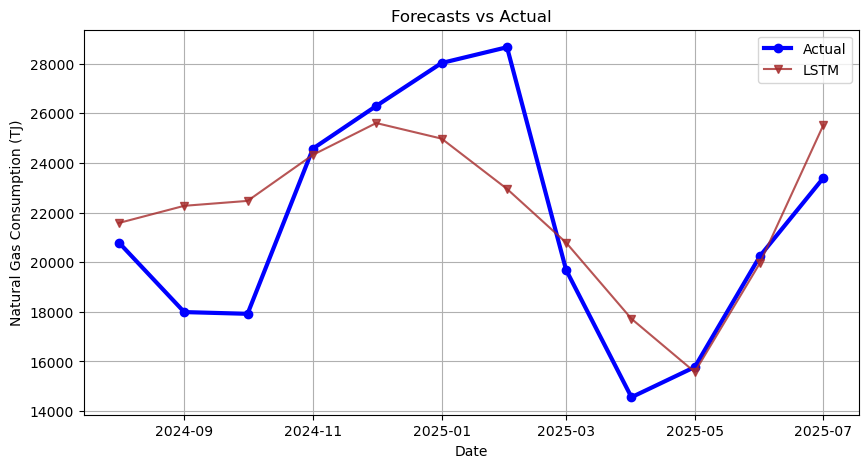

In [37]:
# Plot actuals vs predictions
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual', color='blue', linewidth=3)
plt.plot(test_supervised.index, y_pred_recursive_lstm, marker='v', label='LSTM', color='brown', alpha=0.8)
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**  
- The LSTM achieves the best overall performance, with the lowest MAE and RMSE. Its predictions for November, December, March, May, June and August were especially accurate, almost overlapping with the actual values. This shows the LSTM’s strength in capturing both temporal dependencies and seasonal dynamics.  

#### 2.6 Recurrent Neural Network With Gated Recurrent Units (GRU)

In [38]:
# GRU FORECASTING AND EVALUATION

# we again set the seed number to 42 for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Build GRU model 
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(64, activation='tanh', return_sequences=True, input_shape=(n_lags, 2)),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile 
from tensorflow.keras.optimizers import Adam
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train 
history = model_gru.fit(
    X_train_rnn_scaled, y_train_rnn_scaled,
    epochs=120,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    verbose=0,
    callbacks=[early_stop]
)

# Recursive multi-step forecasting
y_pred_recursive_gru = []
last_sequence = X_train_rnn_scaled[-1].copy()   # last training sequence

# we again set the seed number to 42 for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

for i in range(12):
    # Predict scaled value
    next_pred_scaled = model_gru.predict(last_sequence.reshape(1, n_lags, 2), verbose=0)[0,0]
    
    # Convert to original scale
    next_pred_orig = scaler_y.inverse_transform([[next_pred_scaled]])[0,0]
    y_pred_recursive_gru.append(next_pred_orig)
    
    # Prepare new feature entry (scaled)
    new_entry_orig = np.array([next_pred_orig, test_temp[i]])  # original scale
    new_entry_scaled = scaler_X.transform(new_entry_orig.reshape(1,-1))[0]
    
    # Update rolling window
    last_sequence = np.vstack([last_sequence[1:], new_entry_scaled])

# Convert to array
y_pred_recursive_gru = np.array(y_pred_recursive_gru)


In [39]:
# Calculate MAE and RMSE for GRU and compare
gru_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_gru)
gru_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_gru)
gru_rmse = np.sqrt(gru_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}, MLP RMSE: {mlp_rmse:.2f}")
print(f"RNN MAE: {rnn_mae:.2f}, RNN RMSE: {rnn_rmse:.2f}")
print(f"LSTM MAE: {lstm_mae:.2f}, LSTM RMSE: {lstm_rmse:.2f}")
print(f"GRU MAE: {gru_mae:.2f}, GRU RMSE: {gru_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03
MLP MAE: 3076.47, MLP RMSE: 3763.76
RNN MAE: 2801.40, RNN RMSE: 3252.99
LSTM MAE: 2183.64, LSTM RMSE: 2858.67
GRU MAE: 2448.13, GRU RMSE: 3218.05


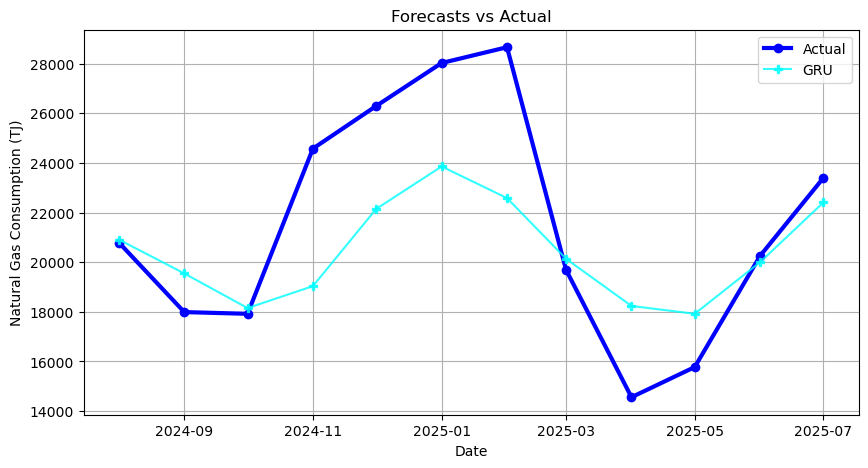

In [40]:
# Plot actuals vs predictions
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual', color='blue', linewidth=3)
plt.plot(test_supervised.index, y_pred_recursive_gru, marker='P', label='GRU', color='cyan', alpha=0.8)
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**  
- The GRU performs strongly, with lower MAE and RMSE than SARIMA, XGBoost, MLP, and the vanilla RNN, though it does not reach the accuracy of the LSTM. Its ability to capture temporal dependencies makes it a reliable model, striking a balance between complexity and predictive performance.  

#### 2.7 1D Convolutional Neural Network (1D-CNN)

In [41]:
# 1D-CNN FORECASTING AND EVALUATION


# we again set the seed number to 42 for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Build 1D-CNN model 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D

model_cnn = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=(n_lags, 2)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1)
])



# Compile 
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')



# Train 
history = model_cnn.fit(
    X_train_rnn_scaled, y_train_rnn_scaled,
    epochs=120,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    verbose=0
)

# we again set the seed number to 42 for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Recursive multi-step forecasting 
y_pred_recursive_cnn = []
last_sequence = X_train_rnn_scaled[-1].copy()   # last training sequence

for i in range(12):
    # Predict scaled value
    next_pred_scaled = model_cnn.predict(last_sequence.reshape(1, n_lags, 2), verbose=0)[0,0]
    
    # Convert back to original scale
    next_pred_orig = scaler_y.inverse_transform([[next_pred_scaled]])[0,0]
    y_pred_recursive_cnn.append(next_pred_orig)
    
    # Prepare new feature entry (scaled)
    new_entry_orig = np.array([next_pred_orig, test_temp[i]])  # original scale
    new_entry_scaled = scaler_X.transform(new_entry_orig.reshape(1,-1))[0]
    
    # Update rolling window
    last_sequence = np.vstack([last_sequence[1:], new_entry_scaled])

# Convert to array
y_pred_recursive_cnn = np.array(y_pred_recursive_cnn)


In [42]:
# Calculate MAE and RMSE for CNN and compare
cnn_mae = mean_absolute_error(test_supervised['y'], y_pred_recursive_cnn)
cnn_mse = mean_squared_error(test_supervised['y'], y_pred_recursive_cnn)
cnn_rmse = np.sqrt(cnn_mse)

print(f'SARIMA MAE: {sarima_mae:.2f}, SARIMA RMSE: {sarima_rmse:.2f}')
print(f"XGBoost MAE: {xgboost_mae:.2f}, XGBoost RMSE: {xgboost_rmse:.2f}")
print(f"MLP MAE: {mlp_mae:.2f}, MLP RMSE: {mlp_rmse:.2f}")
print(f"RNN MAE: {rnn_mae:.2f}, RNN RMSE: {rnn_rmse:.2f}")
print(f"LSTM MAE: {lstm_mae:.2f}, LSTM RMSE: {lstm_rmse:.2f}")
print(f"GRU MAE: {gru_mae:.2f}, GRU RMSE: {gru_rmse:.2f}")
print(f"CNN MAE: {cnn_mae:.2f}, CNN RMSE: {cnn_rmse:.2f}")

SARIMA MAE: 2627.43, SARIMA RMSE: 3379.55
XGBoost MAE: 3373.54, XGBoost RMSE: 4514.03
MLP MAE: 3076.47, MLP RMSE: 3763.76
RNN MAE: 2801.40, RNN RMSE: 3252.99
LSTM MAE: 2183.64, LSTM RMSE: 2858.67
GRU MAE: 2448.13, GRU RMSE: 3218.05
CNN MAE: 2651.28, CNN RMSE: 3474.77


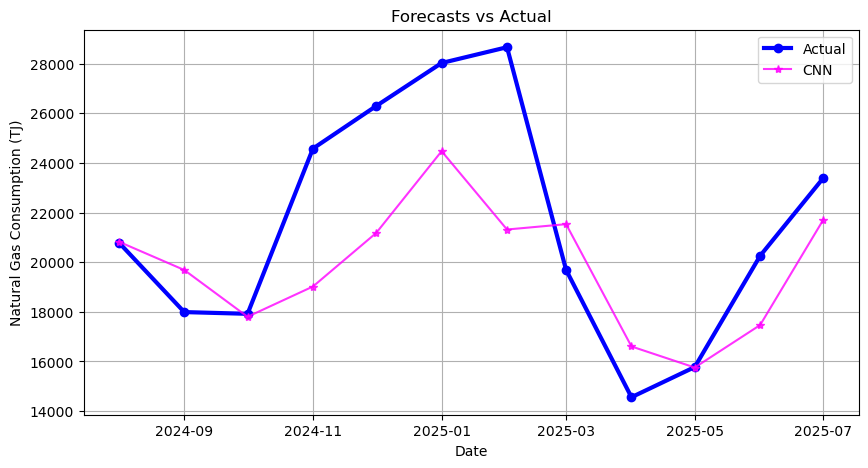

In [43]:
# Plot actuals vs predictions
plt.figure(figsize=(10,5))
plt.plot(test_supervised.index, test_supervised['y'], marker='o', label='Actual', color='blue', linewidth=3)
plt.plot(test_supervised.index, y_pred_recursive_cnn, marker='*', label='CNN', color='magenta', alpha=0.8)
plt.title('Forecasts vs Actual')
plt.xlabel('Date')
plt.ylabel('Natural Gas Consumption (TJ)')
plt.legend()
plt.grid(True)
plt.show()

**Comment:**  
- The 1D-CNN achieves results close to SARIMA, with slightly higher MAE and RMSE. While CNNs are typically designed for image data, their ability to capture local patterns makes them adaptable to time-series forecasting. In this case, the CNN performs reasonably well, but it does not match the accuracy of the LSTM and GRU models, which are better suited to sequential dependencies.  


### **3. Results section**

#### 3.1 Result-tables

In [44]:
# Results dictionary
results = {
    "SARIMA": {"MAE": 2627.43, "RMSE": 3379.55},
    "XGBoost": {"MAE": 3373.54, "RMSE": 4514.03},
    "MLP": {"MAE": 3076.47, "RMSE": 3763.76},
    "RNN": {"MAE": 2801.40, "RMSE": 3252.99},
    "LSTM": {"MAE": 2183.64, "RMSE": 2858.67},
    "GRU": {"MAE": 2448.13, "RMSE": 3218.05},
    "CNN": {"MAE": 2651.28, "RMSE": 3474.77}
}

# Convert to DataFrame
df = pd.DataFrame(results).T

# Rankings
df_mae = df.sort_values(by="MAE").reset_index().rename(columns={"index": "Model"})
df_rmse = df.sort_values(by="RMSE").reset_index().rename(columns={"index": "Model"})

df_mae = df_mae.drop(columns=["RMSE"])
df_rmse = df_rmse.drop(columns=["MAE"])


df_mae.index = df_mae.index+1
df_rmse.index = df_rmse.index+1

In [45]:
# Rankings based on RMSE
df_rmse

,Model,RMSE
1,LSTM,2858.67
2,GRU,3218.05
3,RNN,3252.99
4,SARIMA,3379.55
5,CNN,3474.77
6,MLP,3763.76
7,XGBoost,4514.03


In [46]:
# Rankings based on MAE
df_mae

,Model,MAE
1,LSTM,2183.64
2,GRU,2448.13
3,SARIMA,2627.43
4,CNN,2651.28
5,RNN,2801.40
6,MLP,3076.47
7,XGBoost,3373.54


#### 3.2 Interactive plot

In [47]:
import plotly.graph_objects as go

# X-axis 
months = test_supervised.index  # if index has datetime

# Actual values
actual = test_supervised['y'].values

# Create interactive figure
fig = go.Figure()

# Actual series
fig.add_trace(go.Scatter(x=months, y=actual, mode='lines+markers',
                         name='Actual', line=dict(color='blue', width=3)))

# Forecasts
fig.add_trace(go.Scatter(x=months, y=y_pred_sarima, mode='lines+markers', name='SARIMA', line=dict(color="orange"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_xgb, mode='lines+markers', name='XGBoost', line=dict(color="green"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_mlp, mode='lines+markers', name='MLP', line=dict(color="purple"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_rnn, mode='lines+markers', name='RNN', line=dict(color="red"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_lstm, mode='lines+markers', name='LSTM', line=dict(color="brown"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_gru, mode='lines+markers', name='GRU', line=dict(color="cyan"), visible="legendonly"))
fig.add_trace(go.Scatter(x=months, y=y_pred_recursive_cnn, mode='lines+markers', name='1D-CNN', line=dict(color="magenta"), visible="legendonly"))

# Layout settings
fig.update_layout(
    title="Natural Gas Demand Forecasting - Interactive Plot",
    xaxis_title="Month",
    yaxis_title="Consumption (TJ)",
    hovermode="x unified",
    xaxis=dict(showgrid=True, gridcolor="grey", gridwidth=1, dtick="M1", tickformat="%b %Y", tickangle=-45),
    yaxis=dict(showgrid=True, gridcolor="grey", gridwidth=1),
    plot_bgcolor="white",
    width=1000,   
    height=600    
)

fig.show()


#### 3.3 Synopsis

#### ► MAE vs RMSE  

**MAE (Mean Absolute Error):**  
- Treats all errors equally.  
- More robust to outliers.  
- Use when we care about the *average magnitude* of error.  

**RMSE (Root Mean Squared Error):**  
- Penalizes larger errors more heavily (squared).  
- Sensitive to outliers.  
- Use when large deviations are especially costly (e.g., underestimating winter demand).  



→ In **energy consumption forecasting**, **RMSE is often prioritized** because large errors in peak demand periods matter more.  
→ **MAE is still useful** for general interpretability (average deviation).  

---
---

#### ► Model Performance
- **Best overall:** LSTM achieved the most consistent results, showing strong ability to capture temporal dependencies in the data.  
- **Next best:** GRU followed closely, performing well with slightly faster training compared to LSTM, making it a good balance between accuracy and efficiency.  
- **Traditional model (SARIMA):** provided stable forecasts even without temperature as an input.  
- **Tree-based model (XGBoost):** performed the weakest. With only 211 rows of data, it struggled to generalize, as tree-based models typically need larger datasets.  
- **CNN & RNN:** achieved relatively good results. Both RNN and CNN captured sequential patterns but both were outperformed by LSTM/GRU. CNN in particular requires larger datasets to fully leverage its strengths.  

→ **Training times:** SARIMA trained quickly. XGBoost was efficient. Neural networks (MLP, RNN, CNN, GRU, LSTM) required more time, with LSTM being the most computationally demanding.  

→ **Limitations:** None of the models successfully predicted the extreme peak consumption in January and especially February 2025. Despite average temperatures being low (8.7 °C in January and 8.2 °C in February), the models underestimated demand spikes. This indicates that additional explanatory variables (e.g., socioeconomic factors, policy changes, or sudden demand shocks) may be necessary, since temperature alone and past consumption patterns could not fully explain the anomaly.  


